In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import os

Mounted at /content/gdrive/


In [3]:
image_size = [224, 224]
train_path='/content/gdrive/MyDrive/Cotton disease/train/'
test_path='/content/gdrive/MyDrive/Cotton disease/test/'

In [4]:
resnet = ResNet50(input_shape = image_size + [3], weights = 'imagenet', include_top = False)

94781440/94765736 [==============================] - 0s 0us/step


In [5]:
for layers in resnet.layers:
  layers.trainable = False

In [6]:
folders = glob('/content/gdrive/MyDrive/Cotton disease/train/*')

In [7]:
x = Flatten()(resnet.output)

In [8]:
len(folders)

4

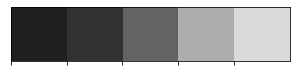

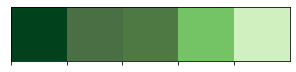

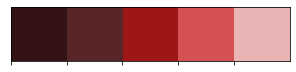

In [9]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [10]:
labels = []
def data_info():
  for i in range(len(folders)):
    labels.append(folders[i])
  return labels

In [11]:
data_info()

['/content/gdrive/MyDrive/Cotton disease/train/fresh cotton plant',
 '/content/gdrive/MyDrive/Cotton disease/train/fresh cotton leaf',
 '/content/gdrive/MyDrive/Cotton disease/train/diseased cotton plant',
 '/content/gdrive/MyDrive/Cotton disease/train/diseased cotton leaf']

In [12]:
X_train =[]
y_train =[]
for i in labels:
    folderPath = os.path.join('/content/gdrive/MyDrive/Cotton disease/Train',i)
    for j in tqdm(os.listdir(folderPath), ncols = 120, desc = 'Training: '+str(i.split('/')[-1])):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size[0], image_size[1]))
        X_train.append(img)
        y_train.append(i)

Training: diseased cotton leaf: 100%|█████████████████████████████████████████████████| 288/288 [00:04<00:00, 63.96it/s]


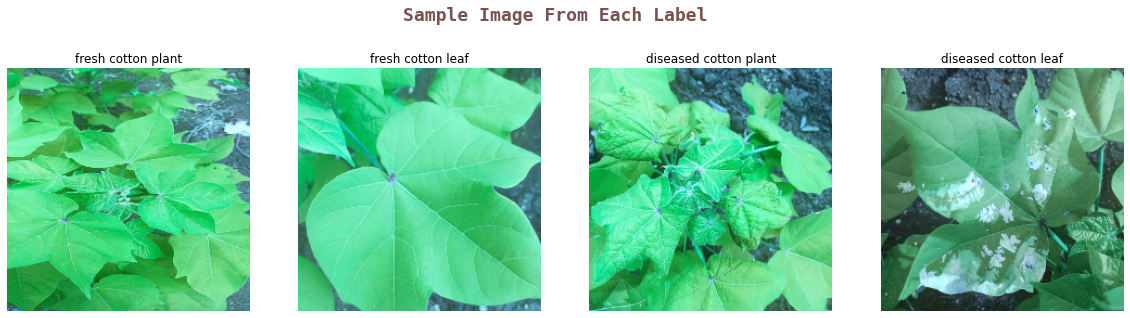

In [13]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_red[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j].split('/')[-1])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [14]:
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs = resnet.input, outputs = prediction)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
model.compile(optimizer='Adam', loss='categorical_crossentropy' ,metrics = ['accuracy'])

In [17]:
train_data_gen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [18]:
training_set = train_data_gen.flow_from_directory(train_path, target_size=(224,224), batch_size=32, class_mode='categorical')

Found 1951 images belonging to 4 classes.


In [19]:
testing_set = test_data_gen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 18 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


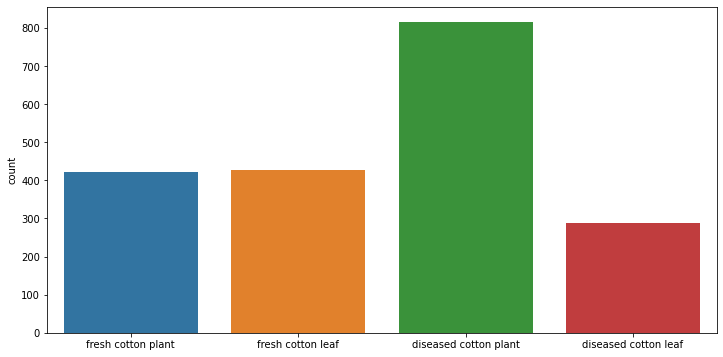

In [20]:
y = []
for i in range(len(y_train)):
  y.append(y_train[i].split('/')[-1])
plt.figure(figsize=(12 ,6))
sns.countplot(y)
plt.show()

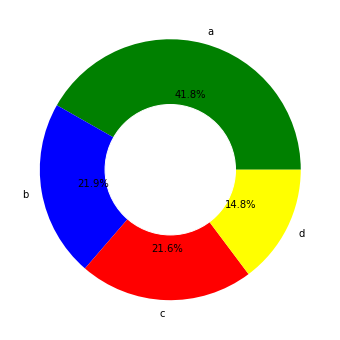

In [21]:
y_train = pd.DataFrame(y_train)
equilibre = y_train.value_counts()
plt.figure(figsize=(12,6))
my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(equilibre, labels=['a','b','c','d'], colors=['green','blue','red','yellow'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [22]:
# training|fitting the model
r = model.fit_generator(
    training_set, 
    validation_data=testing_set, 
    epochs=20, 
    steps_per_epoch=len(training_set),
    validation_steps=len(testing_set) 
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
61/61 [==============================] - 63s 809ms/step - loss: 2.8164 - accuracy: 0.4259 - val_loss: 1.1108 - val_accuracy: 0.5556
Epoch 2/20
61/61 [==============================] - 37s 598ms/step - loss: 0.9458 - accuracy: 0.6192 - val_loss: 1.1510 - val_accuracy: 0.6111
Epoch 3/20
61/61 [==============================] - 37s 607ms/step - loss: 0.9286 - accuracy: 0.6253 - val_loss: 0.9533 - val_accuracy: 0.6111
Epoch 4/20
61/61 [==============================] - 42s 687ms/step - loss: 0.9403 - accuracy: 0.6356 - val_loss: 0.7915 - val_accuracy: 0.6667
Epoch 5/20
61/61 [==============================] - 37s 608ms/step - loss: 0.9113 - accuracy: 0.6299 - val_loss: 1.0397 - val_accuracy: 0.7778
Epoch 6/20
61/61 [==============================] - 37s 608ms/step - loss: 0.8789 - accuracy: 0.6494 - val_loss: 0.8230 - val_accuracy: 0.7222
Epoch 7/20
61/61 [==============================] - 38s 619ms/step - loss: 0.8269 - accuracy: 0.6904 - val_loss: 1.2939 - val_accuracy: 0.6667

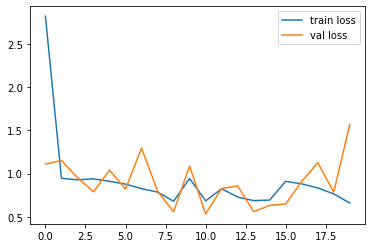

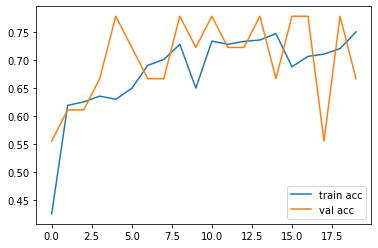

<Figure size 432x288 with 0 Axes>

In [24]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
print("=================================================")
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
pred = model.predict(testing_set)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(testing_set,axis=1)

In [ ]:
print(classification_report(y_test_new,pred))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True, cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold', fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)
plt.show()